In [1]:
import sys
sys.path.append("../../src")
import os
from solver_1DBurger import get_data_1DBurger, residual
import numpy as np
import pickle
from autoencoder import full_network
from training import create_feed_dictionary, create_feed_dictionary2

from sindy_utils import *
from error_utils import *
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression
import copy
from solver_1DBurger import get_data_1DBurger

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 9768
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 15295
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 15295
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 15295


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

In [4]:
data_path = os.getcwd() + '/fig/nCase441_k1_MRN_ld5_subsize50_upfreq2000/'

save_name = 'burger_2021_11_26_21_50_45'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
activation = params['activation']
lamb1 = params['loss_weight_sindy_x']
lamb2 = params['loss_weight_sindy_z']
lamb3 = params['loss_weight_sindy_regularization']
scaled = False
if scaled:
    scaler_x = params['scaler_x']
    scaler_dx = params['scaler_dx']
params['coeff_exist'] = False
params['config'] = config
params['diff'] = 'symb'

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [5]:
print(params['convex_knn'], params['num_test'], params['tol2'], 
      params['update_epoch'], params['max_epochs'], params['subsize_max'])

1 441 2 2000 120000 60


In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [7]:
def eval_perf(test_data, params, test_param, idx=None, knn=1, calc_dz=False):  
    timer = []
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    if 'include_sine' in params.keys():
        include_sine = params['include_sine']
    else:
        include_sine = False
        
    if 'include_cosine' in params.keys():
        include_cosine = params['include_cosine']
    else:
        include_cosine = False
        
    sind_coeff_all = params['model_params'][0] # coefficients of all local SINDys
    z_encoder = NN(test_data['x'], params['model_params'][1], params['model_params'][2], activation) # encoder
    u_decoder = NN(z_encoder, params['model_params'][3], params['model_params'][4], activation) # decoder
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local SINDy: {idx+1}")
        sindy_coeff = sind_coeff_all[idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()

        sindy_coeff = np.zeros(sind_coeff_all[0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * sind_coeff_all[kidx]
    
    
    # Step 4: lastent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_sim = sindy_simulate(z_encoder[0,:], test_data['t'].squeeze(), 
                           sindy_coeff, params['poly_order'], 
                           include_sine,include_cosine)
    u_sim = NN(z_sim, params['model_params'][3], params['model_params'][4], activation)
        
    timer.append(time())
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]

    if calc_dz:
        dz_encoder = derivative(z_encoder)
        dz_sim = derivative(z_sim)
    else:
        dz_encoder = 0
        dz_sim = 0
        
    return u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom

In [8]:
def residual_norm(u0, u1, c, idxn1):
    return np.linalg.norm(residual(u0, u1, c, idxn1))

### Interpolative prediction

In [9]:
nx = params['pde']['nx']
nt = params['pde']['nt']
tstop = params['pde']['tstop']
x = np.linspace(-3,3,nx)
dx = 6 / (nx - 1)
dt = tstop / nt 
c = dt / dx
t = np.linspace(0,tstop,nt+1)

# idxn1 = np.zeros(nx-1,dtype='int')
# idxn1[1:] = np.arange(nx-2)
# idxn1[0] = nx-2

idxn1 = np.zeros(nx,dtype='int')
idxn1[1:] = np.arange(nx-1)
idxn1[0] = nx-1

amp_arr = np.array([0.7])
width_arr = np.array([0.9])

In [10]:
# load testing data
test_data = pickle.load(open(f"./data/local1_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.p", "rb"))

# generate testing data
# test_data = get_data_1DBurger(amp_arr, width_arr)


test_data_x = test_data['data'][0]['x']
if scaled:
    test_data['data'][0]['x'] = scaler_x.transform(test_data['data'][0]['x'])
    test_data['data'][0]['dx'] = scaler_dx.transform(test_data['data'][0]['dx'])

In [11]:
train_param = np.vstack(params['param'])
test_param = np.array([amp_arr[0], width_arr[0]])
idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
print(f"index of the nearest local SINDy: {idx+1}")

index of the nearest local SINDy: 1


In [12]:
u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom = eval_perf(test_data['data'][0], 
                                                                                   params, test_param, calc_dz = True)
u_decoder = u_decoder.squeeze()
print(z_sim.shape, u_sim.shape, u_decoder.shape)

Index of the nearest local SINDy: 1
(1001, 5) (1001, 1001) (1001, 1001)


In [13]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_sindy = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max sindy-decoder error: {err_sindy.max():.2f} %')

max autoencoder error: 0.55 %
max sindy-decoder error: 0.55 %


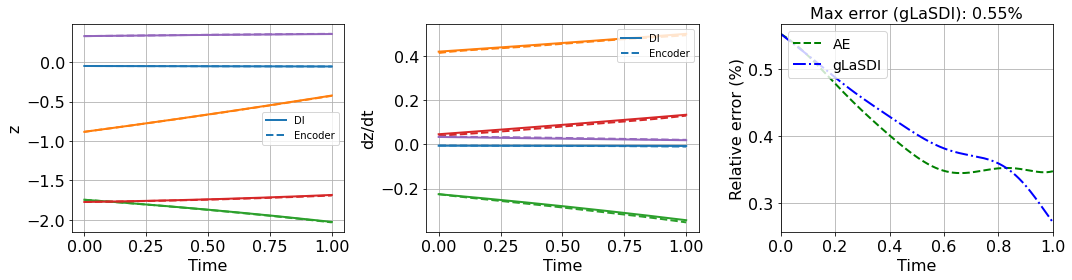

In [14]:
fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_sim.shape[1]):
    ax.plot(t, z_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, z_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'])
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

ax = fig1.add_subplot(132)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_sim[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t, dz_encoder[:,i], '--', linewidth=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['DI', 'Encoder'])
ax.grid()
# ax.set_title('DI predicted latent dynamics', fontsize=14)

# ax = fig1.add_subplot(132)
# ax.plot(x, test_data['data'][0]['x'][-1,:], 'r', linewidth=2, label='Data')
# ax.plot(x, u_decoder[-1,:], 'g--', linewidth=2, label='AE')
# ax.plot(x, u_sim[-1,:], 'b-.', linewidth=2, label='gLaSDI')
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('u', fontsize=16)
# ax.tick_params(axis='both', labelsize=16)
# ax.grid()
# ax.legend(fontsize=14, loc='upper left')
# ax.set_title(f'Local DI index: {idx+1}', fontsize=16)
# ax.set_xlim(-3,3)
# # ax.set_title('SINDy + Decoder', fontsize=16)

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_sindy, 'b-.', linewidth=2, label='gLaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.set_xlim(0,1)
ax.set_title(f'Max error (gLaSDI): {err_sindy.max():.2f}%', fontsize=16)
ax.legend(fontsize=14, loc='upper left')

plt.tight_layout()
plt.savefig(data_path + f"inter_pred_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")

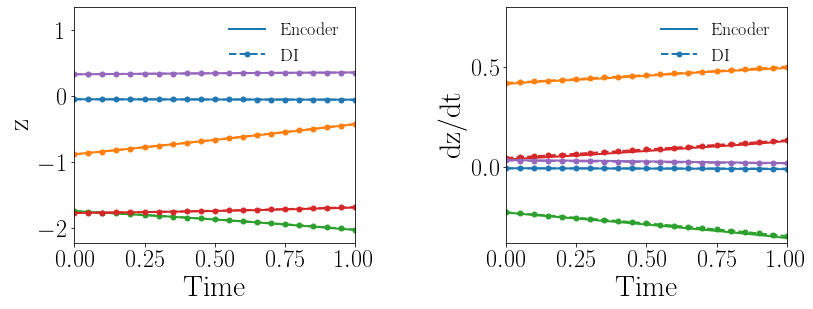

In [16]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,50)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()+1)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()+0.3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"1Dburger_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [17]:
knn = 3
res_nstep = nt
res_name = f'mean'


amp_test = params['test_param'][:,0]
width_test = params['test_param'][:,1]
# amp_test = np.linspace(0.6,1.0,18)
# width_test = np.linspace(0.8,1.2,18)
num_case = amp_test.size * width_test.size
max_err = np.zeros([len(amp_test), len(width_test)])
mse_map = np.zeros([len(amp_test), len(width_test)])
res_norm = np.zeros([len(amp_test), len(width_test)])
sindy_idx = np.zeros([len(amp_test), len(width_test)])
test_data = pickle.load(open(f"./data/local{num_case}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f"{count}/{num_case}: {test_data['param'][count]}")
        
        u_decoder,u_sim,_,_,_,_,idx,t_rom = eval_perf(test_data['data'][count], params, 
                                                 test_data['param'][count], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # MSE of all time steps
        mse = np.linalg.norm(test_data['data'][count]['x'] - u_sim)**2
        mse_map[i,j] = mse
        
        # Max error of all time steps
        max_err[i,j] = (np.linalg.norm(test_data['data'][count]['x'] - u_sim, axis=1) \
                        / np.linalg.norm(test_data['data'][count]['x'], axis=1)*100).max()
        
        # residual norm
        res = []
        for k in range(nt):
            res.append(residual_norm(u_sim[k,:], u_sim[k+1,:], c, idxn1))
        res_norm[i,j] = np.stack(res).mean()
        count += 1

end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.3 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Max relative error: {max_err.max() :.2f} %')
print(f'Average MSE: {mse_map.sum() / num_case:.2f}')
print(f'Average speed up: {speed_up:.2f}')
# for i,t in enumerate(timer_rom):
#     print(f'ROM time{i}: {t:.8f} s')

0/441: [0.7 0.9]
1/441: [0.7  0.91]
2/441: [0.7  0.92]
3/441: [0.7  0.93]
4/441: [0.7  0.94]
5/441: [0.7  0.95]
6/441: [0.7  0.96]
7/441: [0.7  0.97]
8/441: [0.7  0.98]
9/441: [0.7  0.99]
10/441: [0.7 1. ]
11/441: [0.7  1.01]
12/441: [0.7  1.02]
13/441: [0.7  1.03]
14/441: [0.7  1.04]
15/441: [0.7  1.05]
16/441: [0.7  1.06]
17/441: [0.7  1.07]
18/441: [0.7  1.08]
19/441: [0.7  1.09]
20/441: [0.7 1.1]
21/441: [0.71 0.9 ]
22/441: [0.71 0.91]
23/441: [0.71 0.92]
24/441: [0.71 0.93]
25/441: [0.71 0.94]
26/441: [0.71 0.95]
27/441: [0.71 0.96]
28/441: [0.71 0.97]
29/441: [0.71 0.98]
30/441: [0.71 0.99]
31/441: [0.71 1.  ]
32/441: [0.71 1.01]
33/441: [0.71 1.02]
34/441: [0.71 1.03]
35/441: [0.71 1.04]
36/441: [0.71 1.05]
37/441: [0.71 1.06]
38/441: [0.71 1.07]
39/441: [0.71 1.08]
40/441: [0.71 1.09]
41/441: [0.71 1.1 ]
42/441: [0.72 0.9 ]
43/441: [0.72 0.91]
44/441: [0.72 0.92]
45/441: [0.72 0.93]
46/441: [0.72 0.94]
47/441: [0.72 0.95]
48/441: [0.72 0.96]
49/441: [0.72 0.97]
50/441: [0.72 0.

In [18]:
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

In [19]:
max_err_train = []
res_norm_train = []
for i in idx_param:
    idd = i[0]
    max_err_train.append(max_err[idx_list[idd,0],idx_list[idd,1]])
    res_norm_train.append(res_norm[idx_list[idd,0],idx_list[idd,1]])
max_err_train = np.stack(max_err_train)
res_norm_train = np.stack(res_norm_train)
err_ratio_train = res_norm_train / max_err_train
err_ratio_train_mean = err_ratio_train.mean()
res_norm_tol = err_ratio_train_mean * params['tol2']
print(f'tolerance of residual norm (mean): {res_norm_tol:.5f}')
print(f"tolerance of residual norm (reg_max): {params['tol']:.5f}")

tolerance of residual norm (mean): 0.00114
tolerance of residual norm (reg_max): 0.00104


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


1.8549516921020848


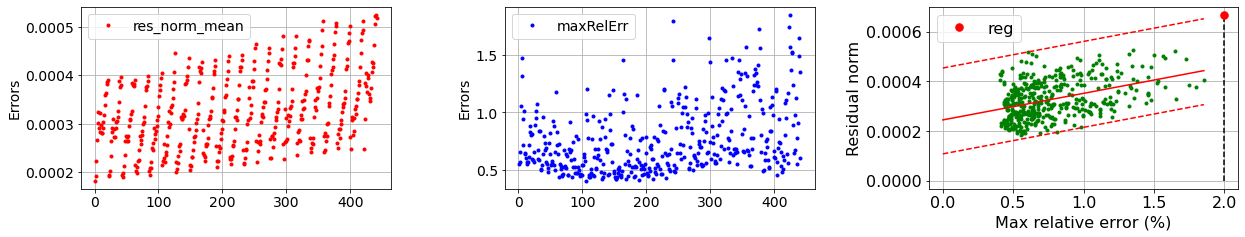

In [20]:
plt.rcParams.update({"text.usetex": False,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(131)
ax.plot(np.arange(1,res_norm.size+1), res_norm.flatten(), 'r.', label='res_norm_'+res_name)
# ax.set_xlabel('Time Steps', fontsize=14)
ax.set_ylabel('Errors', fontsize=14)
ax.tick_params(labelsize=14)
ax.grid()
ax.legend(fontsize=14)

ax = fig.add_subplot(132)
ax.plot(np.arange(1,res_norm.size+1), max_err.flatten(), 'b.', label='maxRelErr')
# ax.set_xlabel('Time Steps', fontsize=14)
ax.set_ylabel('Errors', fontsize=14)
ax.tick_params(labelsize=14)
ax.grid()
ax.legend(fontsize=14)

ax = fig.add_subplot(133)
x = max_err.flatten().reshape(-1,1)
y = res_norm.flatten().reshape(-1,1)
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
y_diff = y - y_pred
x_test = np.linspace(0,max_err.max(),2).reshape(-1,1)
y_test = reg.predict(x_test)
y_test1 = reg.coef_ * x_test + reg.intercept_+ y_diff.min()
y_test2 = reg.coef_ * x_test + reg.intercept_+ y_diff.max()
y_test3 = reg.coef_ * params['tol2'] + reg.intercept_+ y_diff.max()
ax.plot(max_err.flatten(), res_norm.flatten(), 'g.')
ax.plot(x_test,y_test,'r-')
ax.plot(x_test,y_test1,'r--')
ax.plot(x_test,y_test2,'r--')

x_test2 = np.linspace(0,params['tol2'],2).reshape(-1,1)
y_test2 = err_ratio_train_mean * x_test2
# ax.plot(x_test2,y_test2,'b-')
# ax.plot([0,x_test2.max()],[res_norm_tol,res_norm_tol],'b--')
# ax.plot([x_test2.max(),x_test2.max()],[0,max(y_test3,res_norm_tol)],'k--')
# ax.plot(x_test2.max(),res_norm_tol,'b.',markersize=15, label='mean')
# ax.plot(params['tol2'],y_test3,'r.',markersize=15, label='reg')

ax.plot([x_test2.max(),x_test2.max()],[0,min(y_test3,res_norm_tol)],'k--')
if y_test3 < res_norm_tol:
    ax.plot(params['tol2'],y_test3,'r.',markersize=15, label='reg')
else:
    ax.plot(x_test2.max(),res_norm_tol,'b.',markersize=15, label='mean')
plt.legend(fontsize=16)

# y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2 + reg.intercept_[0]
# res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2'] + reg.intercept_[0]
# y_test3 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * x_test2
# res_norm_tol2 = 0.5*(err_ratio_train_mean+reg.coef_[0][0]) * params['tol2']
# ax.plot(x_test2,y_test3,'k-')
# ax.plot([0,x_test2.max()],[res_norm_tol2,res_norm_tol2],'k--')
# ax.plot([x_test2.max(),x_test2.max()],[0,res_norm_tol2],'k--')
# ax.plot(x_test2.max(),res_norm_tol2,'k.',markersizlabel=15)

ax.set_xlabel('Max relative error (%)', fontsize=16)
ax.set_ylabel('Residual norm', fontsize=16)
# ax.set_title('res_norm_'+res_name)
ax.tick_params(labelsize=16)
ax.grid()

plt.tight_layout()
plt.savefig(data_path + f'residual_norm_{res_name}_knn{knn}.png')
print(max_err.max())

In [21]:
# # heat map of max relative errors
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 100:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title('Index of Selected Local SINDy', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_knn{knn}_resNorm_{res_name}.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_knn{knn}_maxRelErr.png', bbox_inches='tight')

#     plt.show()

In [22]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))
    

    # heatmap of max relative errors
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':14}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':14}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Width', fontsize=24)
    ax.set_ylabel('Amplitude', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_knn{knn}_resNorm_{res_name}.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_knn{knn}_maxRelErr.png', bbox_inches='tight')

    plt.show()

idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 217, param: [0.77 1.  ]
idx: 230, param: [0.9 1. ]
idx: 409, param: [0.8  1.09]
idx: 30, param: [0.79 0.91]
idx: 140, param: [0.84 0.96]
idx: 108, param: [0.73 0.95]
idx: 331, param: [0.86 1.05]
idx: 124, param: [0.89 0.95]
idx: 35, param: [0.84 0.91]
idx: 25, param: [0.74 0.91]
idx: 252, param: [0.7  1.02]
idx: 341, param: [0.75 1.06]
idx: 263, param: [0.81 1.02]
idx: 435, param: [0.85 1.1 ]
idx: 335, param: [0.9  1.05]
idx: 246, param: [0.85 1.01]
idx: 59, param: [0.87 0.92]
idx: 112, param: [0.77 0.95]
idx: 157, param: [0.8  0.97]
idx: 424, param: [0.74 1.1 ]
idx: 74, param: [0.81 0.93]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


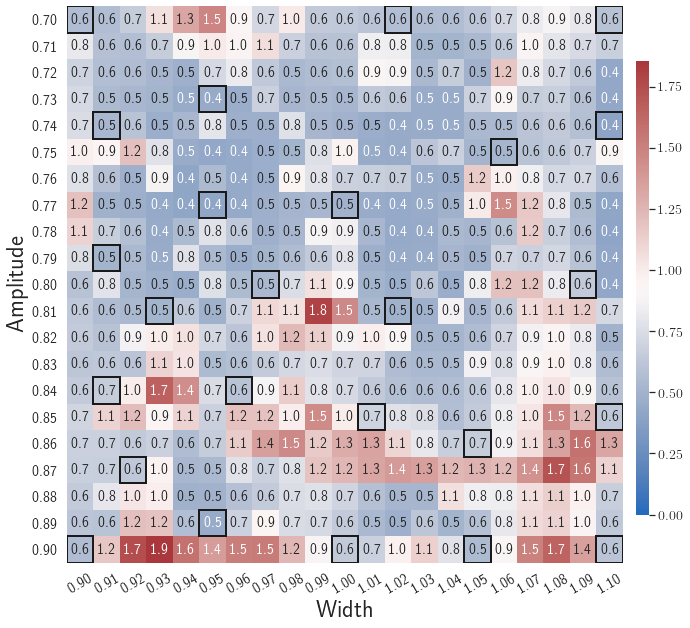

In [25]:
max_err_heatmap(max_err, sindy_idx, idx_list, idx_param, dtype='float')
# max_err_heatmap(max_err, sindy_idx, idx_list, idx_param, dtype='int')

idx: 0, param: [0.7 0.9]
idx: 420, param: [0.7 1.1]
idx: 20, param: [0.9 0.9]
idx: 440, param: [0.9 1.1]
idx: 217, param: [0.77 1.  ]
idx: 230, param: [0.9 1. ]
idx: 409, param: [0.8  1.09]
idx: 30, param: [0.79 0.91]
idx: 140, param: [0.84 0.96]
idx: 108, param: [0.73 0.95]
idx: 331, param: [0.86 1.05]
idx: 124, param: [0.89 0.95]
idx: 35, param: [0.84 0.91]
idx: 25, param: [0.74 0.91]
idx: 252, param: [0.7  1.02]
idx: 341, param: [0.75 1.06]
idx: 263, param: [0.81 1.02]
idx: 435, param: [0.85 1.1 ]
idx: 335, param: [0.9  1.05]
idx: 246, param: [0.85 1.01]
idx: 59, param: [0.87 0.92]
idx: 112, param: [0.77 0.95]
idx: 157, param: [0.8  0.97]
idx: 424, param: [0.74 1.1 ]
idx: 74, param: [0.81 0.93]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


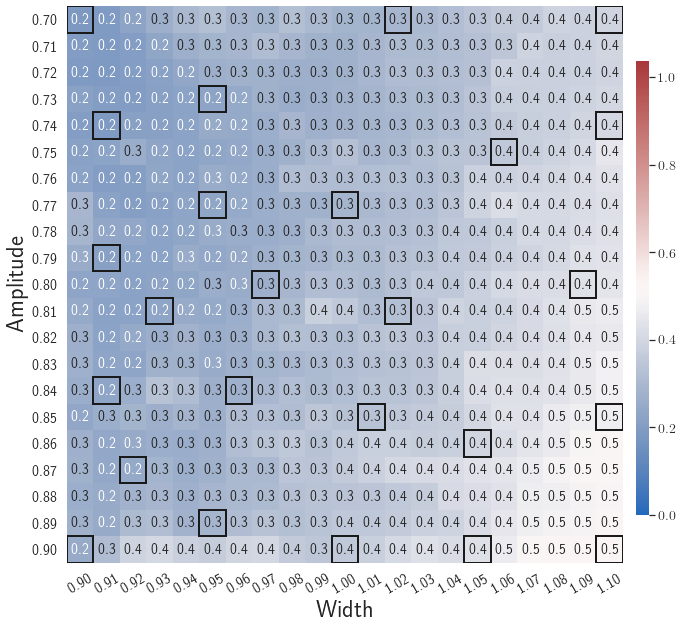

In [24]:
max_err_heatmap(res_norm, sindy_idx, idx_list, idx_param, label='Residual Norm', dtype='float', scale=1000)